In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import re
import pandas as pd
import warnings
import glob
warnings.filterwarnings("ignore")

In [7]:
def newfolder(pathin): # this is a function for making a new folder to save the outputs
    folder = os.path.exists(pathin)
    if not folder:
        os.makedirs(pathin)

In [8]:
pathsave='/Volumes/jiarui/hanako/Acoustic_feature_project/example_results' #path to save the outputs
if os.path.exists(pathsave)==False:
    newfolder(pathsave) # here you are using the newfolder function

In [9]:
def remove_(pathin): # this function is for removing hidden files in Mac os. If it is using in Windows, this function is not necessary.
    for file in glob.glob(os.path.join(pathin, "._*")):
       try:
           os.remove(file)
           print(f"Deleted: {file}")
       except Exception as e:
           print(f"Error deleting {file}: {e}")

In [10]:
path_parent = r"/Volumes/jiarui/hanako/Acoustic_feature_project/example_sounds/PAR" #path to the folder saving parent audio files
path_child = r"/Volumes/jiarui/hanako/Acoustic_feature_project/example_sounds/CHI" #path to the folder saving child audio files
remove_(path_parent) # remove the hidden files in Mac os
remove_(path_child)  # remove the hidden files in Mac os
files_parent= sorted(os.listdir(path_parent)) # read all audio clips in the parent folder
files_child= sorted(os.listdir(path_child)) # read all audio clips in the child folder

In [11]:
def interpolate_f0(f0):
    """
    Interpolates NaN values in the middle of the sequence while keeping NaNs at the edges.
    
    :param f0: Array of fundamental frequency (f0) values with NaNs.
    :return: Interpolated f0 array.
    """
    if np.all(np.isnan(f0)):  # If the entire array is NaN, return as-is
        return f0
    valid_idx = ~np.isnan(f0)  # Indices of valid (non-NaN) values
    if valid_idx.sum() == 0:  # If no valid values, return as-is
        return f0
    # Find the first and last valid index
    first_valid = np.argmax(valid_idx)  # First non-NaN value
    last_valid = len(f0) - np.argmax(valid_idx[::-1]) - 1  # Last non-NaN value
    # Interpolate only in the middle
    interp_values = np.interp(
        np.arange(first_valid, last_valid + 1),
        np.where(valid_idx)[0], 
        f0[valid_idx]
    )
    # Replace only the middle section with interpolated values
    f0_interpolated = np.copy(f0)
    f0_interpolated[first_valid:last_valid + 1] = interp_values
    return f0_interpolated

In [24]:
# This function is for extracting f0 from each audio clip in the folder,
# and output the mean and the std of the pitch for each utterance and the pitch counter.
# The path is the path to the folder saving the audio clips to be processed,
# The files are the audio files in this foler.
# fminin and fmaxin are the boundaries used to extract the f0 (fundamental frequency --> represents pitch in this study).
def f0_ext(path,files,fminin,fmaxin): 
    t1=[]
    t1_c=[]
    for i in range(len(files)):
        x,sr1=librosa.load(path+"/"+files[i],sr=None)
        duration=len(x)/sr1 # duration is always helpful if u want to calculate something like speech rate (number of words/duration)
        f0, voiced_flag, voiced_probs = librosa.pyin(x,sr=sr1,frame_length=512, fill_na=np.nan, n_thresholds=50, fmin=fminin, fmax=fmaxin)
        f0[np.where(f0<(fminin+1))[0]]=np.nan # the f0 has a value of the boundary is always the noise (outlier), so we remove them 
        f0[np.where(f0>(fmaxin-1))[0]]=np.nan
        if (len(np.where(f0>5)[0]))<1: # for the files extracting too little pitch points, we will ignore it and print the file's name, and continue
            print(files[i])            # This is recommended to be used because the audio with too little pitch extracted is not very meaningful to be analyzed.
            continue                   # But please pay attention that this will cause some clips were not included in acoustic feature analysis.
        f0mean=np.round(np.nanmean(f0),decimals=2) # I saved the f0 using two decimals. Just change the decimals=2 to a desired number when using.
        f0std=np.round(np.nanstd(f0),decimals=2)
        starttime=np.array(files[i].split('.')[0]) # The extracted f0 will be attached to the file's name, and here I used the start time from the begining of the audio.
        starttime = starttime.astype(float)
        t=np.c_[starttime,f0mean,f0std,duration] # Pitch features [mean, max, min, range], starttime is the start time of the audio clip, label is used for labeling parent/child
        t1.append(t)
        # From here, the functions are used to extract the pitch counters. They are helpful to check the quality of the f0 extraction
        f0_interpolated = interpolate_f0(f0)
        t_c=(starttime,f0_interpolated)
        t1_c.append(t_c)
    return np.array(t1)[:,0], t1_c

In [25]:
f0_p,f0_counter_p=f0_ext(path_parent,files_parent,180,500) # I set the min and max boundaries as 180 and 500 for female parents
f0_c,f0_counter_c=f0_ext(path_child,files_child,180,600) # I set the min and max boundaries as 180 and 500 for children

135365.wav
220794.wav
383449.wav
195723.wav
256014.wav
271219.wav
294891.wav


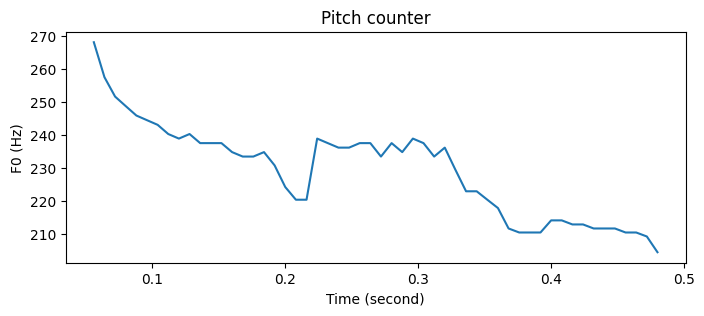

In [33]:
# Let us try to print the pitch counter of the first audio clip of the parent to see how it looks like
plt.figure(figsize=(8, 3))
time_to_plot=np.arange(len(f0_counter_p[0][1]))*128/16000 # This for reformat the time step to original time. The 128 is the hop_length used to extract f0, and 16000 is the sampling rate of the audio. Please change them correspondingly.
plt.plot(time_to_plot,f0_counter_p[0][1]) # change the [0] in f0_counter_p[0][1] to 1,2,..., then you can plot the second, third,... pitch counter. Please pay attention that python always count the index from 0, but not 1 
plt.xlabel("Time (second)")
plt.ylabel("F0 (Hz)")
plt.title("Pitch counter")
#plt.savefig(pathsave+'/'+'name_of_figure',bbox_inches='tight') # This is for saving the figure. Remove the '#' if you want to use it.
plt.show()

In [35]:
# Now we are going to output the calculated results as csv
column_names = ['Start_time (msec)', 'F0_mean', 'F0_STD','Duration'] # Define the column titles
# Convert to DataFrame
df_p = pd.DataFrame(f0_p, columns=column_names)
df_c = pd.DataFrame(f0_c, columns=column_names)
# Save to CSV
df_p.to_csv(pathsave+'/'+'f0_p.csv', index=False) # change 'f0_p.csv' and 'f0_c.csv' to your preferred name for saving the results
df_c.to_csv(pathsave+'/'+'f0_c.csv', index=False)